In [1]:
import os
import sys
import json

import numpy as np
import pandas as pd
import pickle

%matplotlib nbagg
%reload_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt


from matplotlib import cm
from skimage import data, img_as_float

from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter
from scipy.stats import sem

In [2]:
debug = False #or 'False' when you do not want to debug

path = "/Users/sfiligoj/Google Drive/Crispies/Method1/SSP_all"
os.chdir(path)
# Load the dictionary back from the pickle file.
df = pickle.load( open( "save.p", "rb" ) )

In [8]:
# # some files have n_pix == 256, and some have a too small scansize. We discard them
# df.drop(df[df.n_pix==256].index, inplace=True)
df.drop(df[df.scansize==200].index, inplace=True)
df.drop(index=35, inplace=True) # : file016 High density 700C
df=df[df.density=='L']
df=df[df.temp=='25']
df

,filename,density,temp,xi,hhcorr,scansize,n_pix,rms,rms_sq,alpha
4,103,L,25,5.149379,"[0.05403032984331371, 0.1174859846430836, 0.18...",1000,1024,0.416299,0.173305,0.958617
9,101,L,25,4.950383,"[0.07033026839829767, 0.15801006982270607, 0.2...",1000,1024,0.474831,0.225464,0.998945
72,004,L,25,6.600478,"[0.08390102879687368, 0.16508719574923117, 0.2...",1000,512,0.371162,0.137761,0.488224
86,000,L,25,6.756240,"[0.09156047934519809, 0.17685502825332977, 0.2...",1000,512,0.385732,0.148789,0.474876
87,002,L,25,6.220995,"[0.10576732705359355, 0.20779452379242974, 0.2...",1000,512,0.404338,0.163489,0.487118


In [9]:
# we make a column that describes the px_size, we'll use that later
df['px_size'] = df.scansize / df.n_pix
#I dropped out these two px_sizes because they were too big (I could see this when I plotted each HHcorr):
df.drop(df[df.px_size==5000/512].index, inplace=True) 
df.drop(df[df.px_size==10000/512].index, inplace=True)
df.drop(df[df.px_size==30000/512].index, inplace=True)

df

,filename,density,temp,xi,hhcorr,scansize,n_pix,rms,rms_sq,alpha,px_size
4,103,L,25,5.149379,"[0.05403032984331371, 0.1174859846430836, 0.18...",1000,1024,0.416299,0.173305,0.958617,0.976562
9,101,L,25,4.950383,"[0.07033026839829767, 0.15801006982270607, 0.2...",1000,1024,0.474831,0.225464,0.998945,0.976562
72,004,L,25,6.600478,"[0.08390102879687368, 0.16508719574923117, 0.2...",1000,512,0.371162,0.137761,0.488224,1.95312
86,000,L,25,6.756240,"[0.09156047934519809, 0.17685502825332977, 0.2...",1000,512,0.385732,0.148789,0.474876,1.95312
87,002,L,25,6.220995,"[0.10576732705359355, 0.20779452379242974, 0.2...",1000,512,0.404338,0.163489,0.487118,1.95312


In [10]:
# we create Xdelta for each row, all at once
df['x_delta'] = [np.arange(px_size, scan_size+px_size, px_size) 
                     for px_size, scan_size in zip(df.px_size, df.scansize)] 

In [11]:
# we take the minimun px_size, and interpolate all HHcorr at x values whose delta is that minimum
min_dx = min(df.px_size)
min_scansize = min(df.scansize)
if True: print(min_dx, min_scansize)
x_new = np.arange(min_dx, min_scansize, min_dx) # su quali x vogliamo l'interpolazione di HHcorr
#se ho 1024 pix questo mi sistema tutti i file a 512 pix con step size 
# x = np.linspace(0, 2*np.pi, 10) # sara' il nostro Xdelta originale
# y = np.sin(x) # sara' il nostro HHcorr originale
# yinterp = np.interp(x_new, xdelta, HHcorr)

0.9765625 1000


In [12]:
#definition of HHcorr-interpolated:
df['hhcorr_interp'] = [np.interp(x_new, x, y) for x,y in zip(df.x_delta, df.hhcorr)]
for row in df.hhcorr_interp:
    print(len(row))

1023
1023
1023
1023
1023


In [13]:
# AvHHcorr blueprint -> AvHHcorr[density][temperature] = average of all HHcorr for that selection
temperatures = ['25','250','500','600','700','800']
densities = df.density.unique()

AvHHcorr = {} 
for dens in densities:
    AvHHcorr[dens] = {}
    for temp in temperatures:
        AvHHcorr[dens][temp] = {}
        # create the selection
        selection = df[df.temp==temp]
        selection = selection[selection.density==dens]
        # we take the interpolated HHcorr from the "selection" DataFrame
        # we create a matrix, where each HHcorr array from a different measurement is a full row
        # when we average on the columns, we get the average_HHcorr
        all_hhcorr = np.matrix(selection.hhcorr_interp.tolist()) 
        AvHHcorr[dens][temp]['value'] = np.ravel(all_hhcorr.mean(axis = 0))
        err = np.ravel(sem(all_hhcorr, axis = 0))
        AvHHcorr[dens][temp]['err']   = err
        AvHHcorr[dens][temp]['value_upper'] = AvHHcorr[dens][temp]['value'] + err
        AvHHcorr[dens][temp]['value_lower'] = AvHHcorr[dens][temp]['value'] - err
#diz in data

/anaconda3/envs/pina/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


In [ ]:
# *** Calculate average HHcorr from interpolated values, and the associated standard deviation
temperatures = ['25','250','500','600','700','800']
densities = df.density.unique()

row={}
df2 = pd.DataFrame(
        columns= ['density','temp', 'avhhcorr','xdelta','rmssqd'])

# data = [[densities, temperatures, AvHHcorr]
#         for patient, visits in dictionary.items()
#         for visit_num in visits]
# df = pd.DataFrame(data, columns=['patient', 'visit_num']).set_index('patient')
for dens in densities:
    row[dens] = {}
    for temp in temperatures:
        selection = df[df.temp==temp]
        selection = selection[selection.density==dens]
        row[dens][temp] = {}
        #crei la riga:
        row[dens][temp]['density'] = dens
#         row{'avcorrlen'} = value
#         row{'avHHcorr'} = arrays 
        row[dens][temp]['temperature'] = temp
        row[dens][temp]['avHHcorr'] = AvHHcorr[dens][temp]['value']
        row[dens][temp]['rmssqd'] = selection.rms_sq.mean()
        if debug: print(row)
# #*** per ricordarmi cosa ho fatto prima:
# cosa = df[df.temp==t].hhcorr_interp
# sm = np.matrix(cosa.tolist())
# i=0
# temp = sm[:,i] # gli i-esimi elementi di ogni HHcorr del tuo df iniziale
# print(np.std(temp))

# # *** Create new dataframe for the calculation of CorrLen and Alpha on this data:
        df2 = df2.append( 
            {'density': row[dens][temp]['density'],
             'temp': row[dens][temp]['temperature'],  
             'avhhcorr': row[dens][temp]['avHHcorr'], 
             'xdelta': x_new,
             'rmssqd': row[dens][temp]['rmssqd']
            },
            ignore_index=True)
pickle.dump(df2, open( "AvHHcorr_interpolated.p", "wb" ) )
df2

<IPython.core.display.Javascript object>


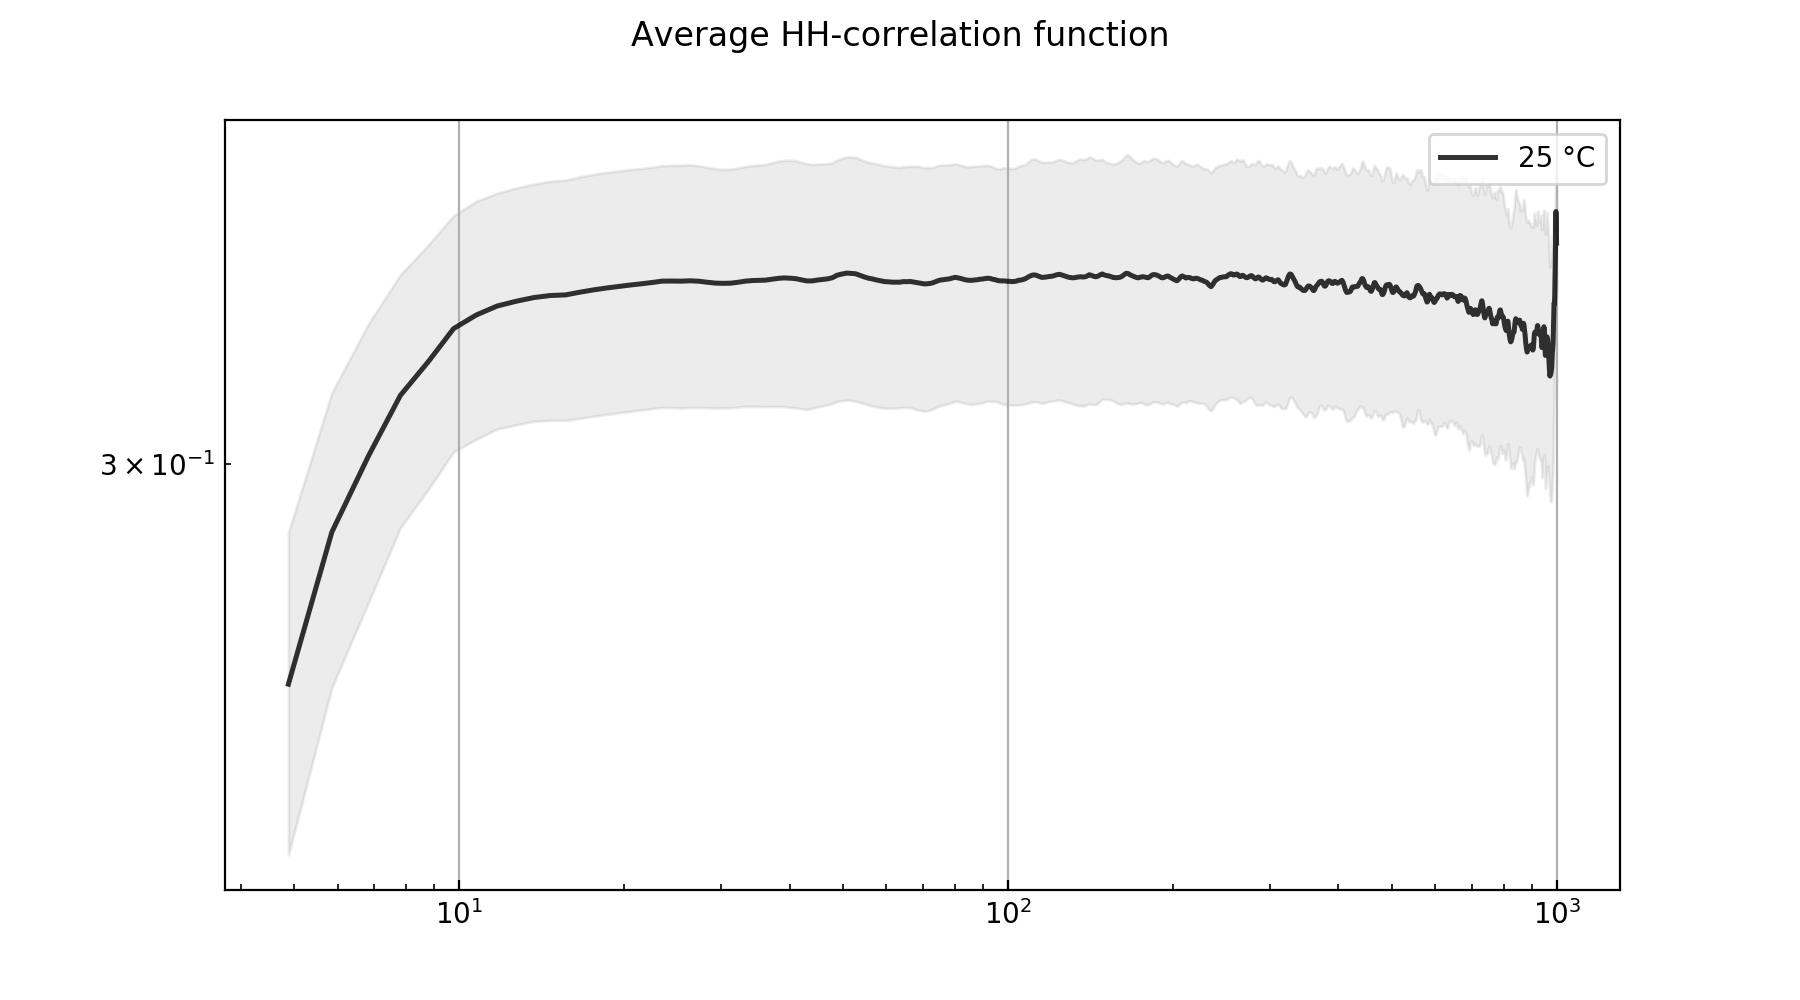

In [14]:
# *** Plot everything in one graph:
plt.style.use('default')
fig, ax = plt.subplots(figsize = (9,5))
temperatures = ['25']
colors = ['black', 'forestgreen','#225ea8', '#ff9900', '#ff0000', '#800000']

for temp, color in zip(temperatures, colors):
    
    density = 'L'
    
    label = f"{temp} °C"
    ax.loglog(
        x_new[4:],
        AvHHcorr[density][temp]['value'][4:],
        c = color,
        alpha = 0.8,
        linewidth = 1.8,
        label = label
    )
    ax.fill_between(
        x_new[4:],
        AvHHcorr[density][temp]['value_lower'][4:],
        AvHHcorr[density][temp]['value_upper'][4:],
        color = color,
        alpha = 0.075
    )

#     ax.scatter(x_new[4], AvHHcorr[temp]['value'][4], c='darkblue', s=5, zorder=10)
    label = None
ax.legend()
ax.tick_params(direction='in')
ax.tick_params(which = 'minor', direction = 'in')
titl = f"Average HH-correlation function"
fig.suptitle(titl)


ax.xaxis.grid() # vertical lines

<IPython.core.display.Javascript object>


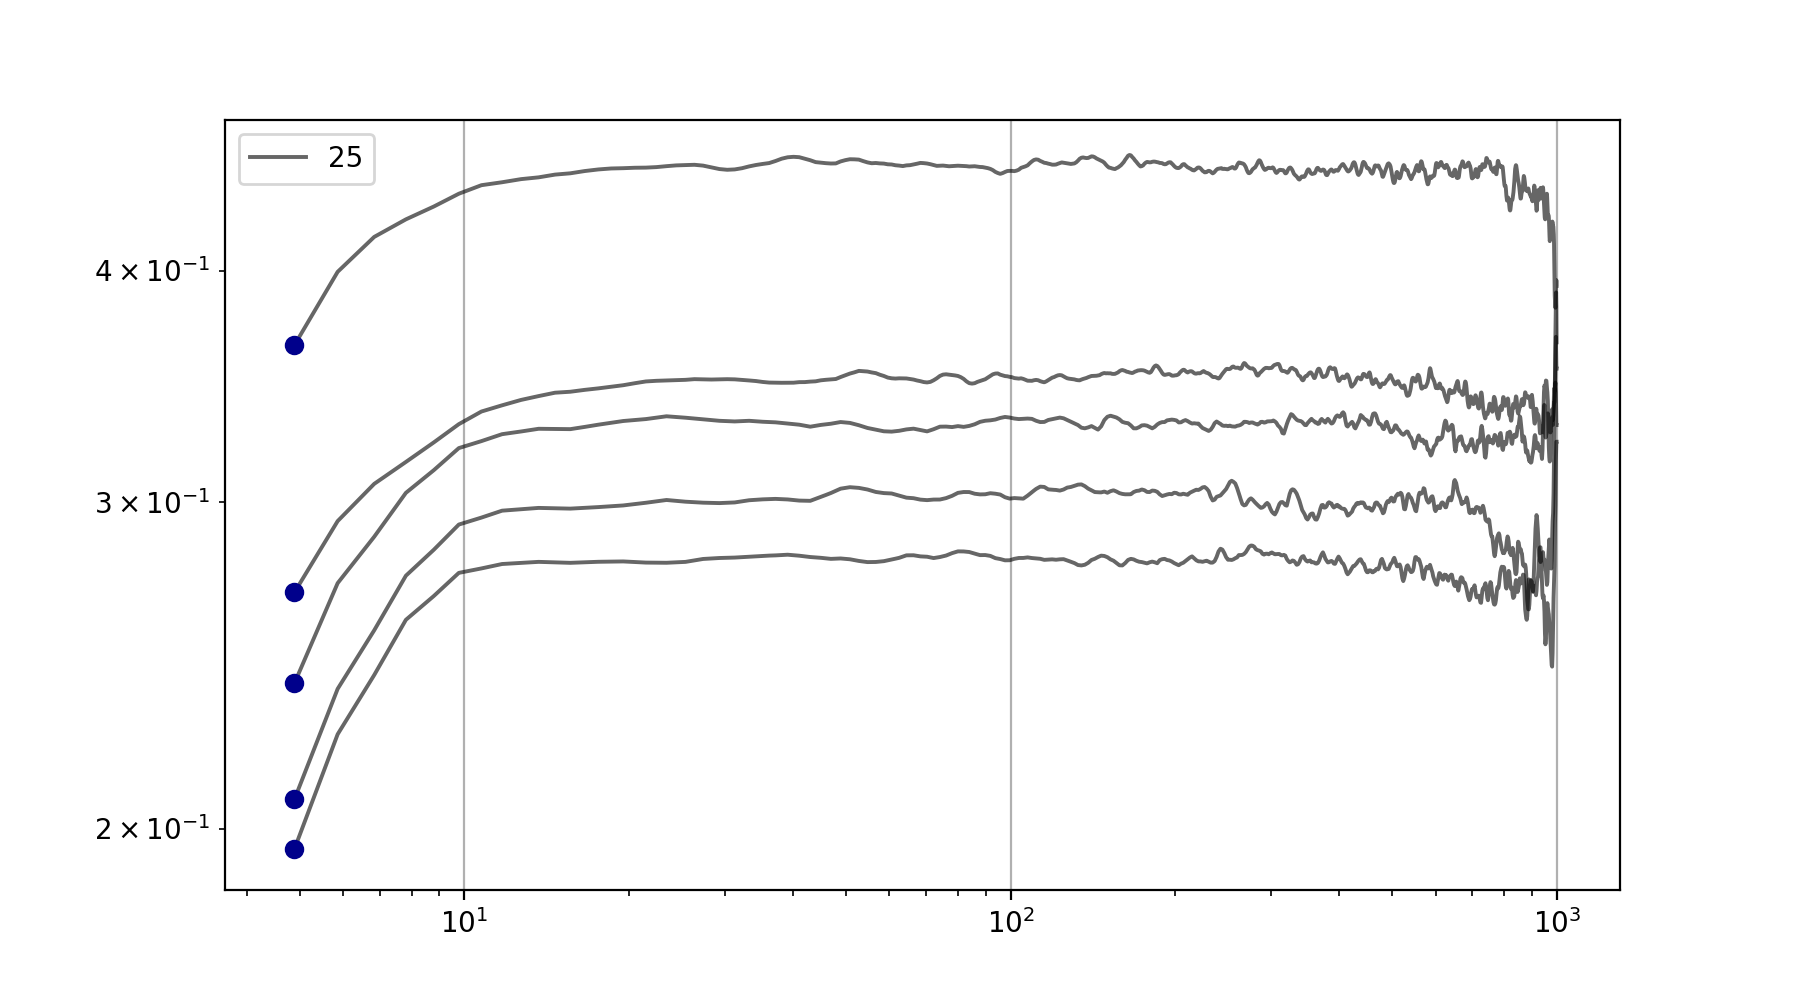

In [15]:
# *** If I want to see each single HHcorr function (interpolated but not averaged)
fig, ax = plt.subplots(figsize = (9,5))
temperatures = ['25','250']
colors = ['black','forestgreen', '#225ea8', '#ff9900', '#ff0000', '#800000']

for temp, color in zip(temperatures, colors):
    selection = df[df.temp==temp]
    selection = selection[selection.density=='L']
    label = temp
    for idx, row in selection.iterrows():
        ax.loglog(
            x_new[4:],
            row.hhcorr_interp[4:],
            c = color,
            alpha = 0.6,
            linewidth = 1.4,
            label = label
        )
        ax.scatter(x_new[4], row.hhcorr_interp[4], c='darkblue', zorder=10)
        label = None
ax.legend()

ax.xaxis.grid() # vertical lines


In [ ]:
# *** to visualize error
fig, ax  = plt.subplots()
ax.plot(
    x_new,
    AvHHcorr[t]['value'],
)
ax.plot(
    x_new,
    AvHHcorr[t]['value_lower'],
)
ax.plot(
    x_new,
    AvHHcorr[t]['value_upper'],
)